### Why Transformers need to applied on patches and not pixels
* If we use self-attention mechanism on image data, then each pixel in an image would need to attend and be compared to every other pixel. 
* The problem is, if we increase the pixel value by one, then the computational cost would increase quadratically. 
* This is simply not feasible if we have an image with a reasonably large resolution.

1) Patching can be done by spliting the image into (no. of patches X (patch_size^2. channel)). Then apply linear layer to embed.
2) Send it to a convolution layer with kernel_size and stride = patch_size. Then we flatten the output


### Attention maps

* The attention maps of Vision Transformer (ViT) are matrices that represent the importance of different parts of an input image to different parts of the model’s learned representations.
* The attention maps can be visualized as a grid of heatmaps, where each heatmap represents the attention weights between a given token and all other tokens
* By analyzing the attention maps, we can gain insights into which parts of the image are most important for the classification task at hand.

### USAGE:
* Image Recognition
* Object detection
* Segmentation
* Image classification

## ViT Model

In [4]:
import sys
!{sys.executable} -m pip install -q datasets

In [29]:
from datasets import load_dataset 

# Load dataset
dataset = load_dataset("Matthijs/snacks", split=['train[:10%]', 'test[:10%]'],)
print(dataset)

[Dataset({
    features: ['image', 'label'],
    num_rows: 484
}), Dataset({
    features: ['image', 'label'],
    num_rows: 95
})]


In [25]:
# from datasets import load_dataset
# ds = load_dataset('imagefolder', data_dir='/path/to/images', split='train')
# print(dataset["train"].features['label'].names)

In [33]:
labels = dataset[0].features["label"].names
num_labels = len(dataset[0].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'apple': 0, 'banana': 1, 'cake': 2, 'candy': 3, 'carrot': 4, 'cookie': 5, 'doughnut': 6, 'grape': 7, 'hot dog': 8, 'ice cream': 9, 'juice': 10, 'muffin': 11, 'orange': 12, 'pineapple': 13, 'popcorn': 14, 'pretzel': 15, 'salad': 16, 'strawberry': 17, 'waffle': 18, 'watermelon': 19}
{0: 'apple', 1: 'banana', 2: 'cake', 3: 'candy', 4: 'carrot', 5: 'cookie', 6: 'doughnut', 7: 'grape', 8: 'hot dog', 9: 'ice cream', 10: 'juice', 11: 'muffin', 12: 'orange', 13: 'pineapple', 14: 'popcorn', 15: 'pretzel', 16: 'salad', 17: 'strawberry', 18: 'waffle', 19: 'watermelon'}


## Forward Pass ViT Model with a Toy Image

In [34]:
import torch
import torch.nn as nn

# Create toy image with dim (batch x channel x width x height)
toy_img = torch.rand(1, 3, 48, 48)

# Define conv layer parameters
num_channels = 3
hidden_size = 768 # or emb_dimension
patch_size = 16

# Conv 2D layer for patching
projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

# Forward pass toy img
out_projection = projection(toy_img)

print(f'Original image size: {toy_img.size()}')
print(f'Size after projection: {out_projection.size()}')

Original image size: torch.Size([1, 3, 48, 48])
Size after projection: torch.Size([1, 768, 3, 3])


In [35]:
## Flatten to merge dimentions
t = torch.tensor([[[[1, 2,3],
                       [3, 4,5]],
                      [[5, 6,7],
                       [7, 8,9]],
                       [[1, 4,4],
                       [3, 5,5]],
                       [[32, 2,3],
                       [33, 4,5]]]])
t = t.flatten(start_dim=1)
t.shape

torch.Size([1, 24])

In [36]:
# Flatten the output after projection with Conv2D layer

patch_embeddings = out_projection.flatten(2).transpose(1, 2)
print(f'Patch embedding size: {patch_embeddings.size()}')
     

Patch embedding size: torch.Size([1, 9, 768])


In [37]:
# Define [CLS] token embedding with the same emb dimension as the patches
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_tokens = cls_token.expand(batch_size, -1, -1)

# Prepend [CLS] token in the beginning of patch embedding
patch_embeddings = torch.cat((cls_tokens, patch_embeddings), dim=1)
print(f'Patch embedding size: {patch_embeddings.size()}')
# patch_embeddings.shape
     

Patch embedding size: torch.Size([1, 10, 768])


In [38]:
# Define position embedding with the same dimension as the patch embedding
position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

# Add position embedding into patch embedding
input_embeddings = patch_embeddings + position_embeddings
print(f'Input embedding size: {input_embeddings.size()}')

Input embedding size: torch.Size([1, 10, 768])


In [39]:
# Define parameters for ViT-base (example)
num_heads = 12
num_layers = 12

# Define Transformer encoders' stack
transformer_encoder_layer = nn.TransformerEncoderLayer(
           d_model=hidden_size, # input dim expected
           nhead=num_heads, # Numbers of heads in multihead attention Layer
           dim_feedforward=int(hidden_size * 4),
           dropout=0.1)

transformer_encoder = nn.TransformerEncoder(
           encoder_layer=transformer_encoder_layer,
           num_layers=num_layers)

# Forward pass
output_embeddings = transformer_encoder(input_embeddings)
print(f' Output embedding size: {output_embeddings.size()}')

 Output embedding size: torch.Size([1, 10, 768])


/Users/jyotsana/miniforge3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Use a pretrained model to infer

In [40]:
from transformers import ViTModel

# Load pretrained model
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

# Example input image
input_img = torch.rand(batch_size, num_channels, 224, 224)

# Forward pass input image
output_embedding = model(input_img)
print(output_embedding)
print(f"Ouput embedding size: {output_embedding['last_hidden_state'].size()}") # 14*14+1

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.0217, -0.2631,  0.0653,  ...,  0.1994,  0.0307, -0.3369],
         [ 0.1496, -0.0639,  0.0941,  ...,  0.0052,  0.0997, -0.2213],
         [-0.1823, -0.3833, -0.0654,  ...,  0.3461,  0.1682, -0.2963],
         ...,
         [ 0.0167, -0.0211,  0.0936,  ...,  0.0873,  0.1019, -0.2928],
         [-0.0425, -0.1755,  0.0703,  ...,  0.1135,  0.0685, -0.3048],
         [ 0.0925, -0.0458,  0.0840,  ..., -0.0124,  0.0555, -0.2924]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)
Ouput embedding size: torch.Size([1, 197, 768])


In [41]:
num_labels = 20

# Define linear classifier layer
classifier = nn.Linear(hidden_size, num_labels) # 768 ,20

# Forward pass on the output embedding of [CLS] token
output_classification = classifier(output_embedding['last_hidden_state'][:, 0, :]) ## CLS token sent for classification
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([1, 20])


## Finetune a Pretrained model

In [42]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

# Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [43]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):
        
      self.input_data = input_data
      
      # Transform input data
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                             std=[0.5, 0.5, 0.5])
        ])

  def __len__(self):
      return len(self.input_data)
    
  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])
  
  def get_labels(self, idx):
      return self.input_data[idx]['label']
  
  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

In [44]:
class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), num_labels=20, 
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels) 
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])

    return output

In [45]:
train_dataset = ImageDataset(dataset[0])
train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=8, shuffle=True)
train_dataloader.dataset[0]

(tensor([[[ 0.9137,  0.9137,  0.9168,  ...,  0.9734,  0.9861,  0.9932],
          [ 0.9127,  0.9127,  0.9158,  ...,  0.9501,  0.9623,  0.9651],
          [ 0.9009,  0.9017,  0.9057,  ...,  0.9197,  0.9287,  0.9333],
          ...,
          [ 0.2161,  0.3289,  0.3024,  ...,  0.5371,  0.6198,  0.5814],
          [ 0.1271,  0.1636,  0.1248,  ...,  0.5279,  0.6291,  0.6246],
          [ 0.0492,  0.0820,  0.0799,  ...,  0.5152,  0.6226,  0.6451]],
 
         [[ 0.8275,  0.8275,  0.8305,  ...,  0.9420,  0.9548,  0.9618],
          [ 0.8264,  0.8264,  0.8295,  ...,  0.9241,  0.9363,  0.9391],
          [ 0.8146,  0.8154,  0.8194,  ...,  0.8962,  0.9052,  0.9098],
          ...,
          [-0.1035,  0.0532,  0.0948,  ...,  0.5065,  0.5830,  0.5493],
          [-0.2674, -0.1738, -0.1312,  ...,  0.4887,  0.5898,  0.5854],
          [-0.4099, -0.3117, -0.2286,  ...,  0.4760,  0.5834,  0.6058]],
 
         [[ 0.6706,  0.6706,  0.6736,  ...,  0.8479,  0.8606,  0.8677],
          [ 0.6696,  0.6696,

In [48]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # device = "mps" if torch.backends.mps.is_available() else "cpu"

    # Load nodel, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataset = ImageDataset(dataset)
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

    return model

# Hyperparameters
EPOCHS = 5
LEARNING_RATE = 1e-4
BATCH_SIZE = 8

# Train the model
trained_model = model_train(dataset[0], EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 61/61 [01:18<00:00,  1.29s/it]


Epochs: 1 | Loss:  0.134 | Accuracy:  0.870


100%|██████████| 61/61 [01:22<00:00,  1.36s/it]


Epochs: 2 | Loss:  0.033 | Accuracy:  0.975


100%|██████████| 61/61 [01:14<00:00,  1.22s/it]


Epochs: 3 | Loss:  0.016 | Accuracy:  0.992


100%|██████████| 61/61 [01:09<00:00,  1.15s/it]


Epochs: 4 | Loss:  0.011 | Accuracy:  0.992


100%|██████████| 61/61 [01:09<00:00,  1.13s/it]

Epochs: 5 | Loss:  0.010 | Accuracy:  0.986


## Prediction/ Inference

In [50]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                             std=[0.5, 0.5, 0.5])
        ])
    
    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

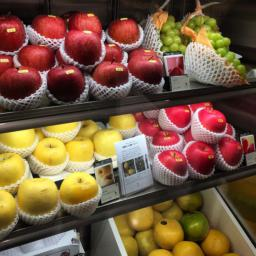

In [52]:
dataset[1][10]['image']

In [54]:
print(predict(dataset[1][10]['image']))

apple
